<a href="https://colab.research.google.com/github/edisonmoy/textualism/blob/master/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis Pipeline

Given a dataset that spans over multiple years, train model per year of data. Analyze performance of models (observe changes in the data) per year.

### Load Data

In [ ]:
# Load model
import os
from google.colab import drive
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings (dangerous)
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive', force_remount=True)
print(os.getcwd())

Mounted at /content/drive
/content


## Load Models

In [ ]:
import re
import collections

filepath = "drive/My Drive/Textualism/Edison + Ritvik Notebooks/GloVe Hyperparameter Search/models/"
model_dict = {}
for folder in os.listdir(filepath):
  model_parts = {}
  
  # Load parts of the model
  try:
    for file in os.listdir(filepath + folder + "/"):
      if "ID" in file:
        part = np.load(filepath + folder + "/" + file, allow_pickle="TRUE").item()
        if "ID2WORD" in file:
          model_parts["ID2WORD"] = part
        else:
          model_parts["WORD2ID"] = part
      else:
        part = np.load(filepath + folder + "/" + file)
        if "Weight_Matrix1" in file:
          model_parts["Weight_Matrix1"] = part
        elif "Weight_Matrix2" in file:
          model_parts["Weight_Matrix2"] = part
        else:
          model_parts["Losses"] = part

    # Organize parts of the model
    word_vectors1 = model_parts["Weight_Matrix1"]
    word_vectors2 = model_parts["Weight_Matrix2"]
    id2word = model_parts["ID2WORD"]
    word2id = model_parts["WORD2ID"]
    losses = model_parts["Losses"]
    model = (word_vectors1,word_vectors2,id2word,word2id,losses) # Order of parts in model
    
    # Get year of current model
    year = re.search(r"(\D*)(\d*)", folder).group(2)
    model_dict[int(year)] = model
  except:
    print(str(folder) + " is not a directory")
print("Done! Loaded " + str(len(model_dict)) + " models (one per years).")

# Sort dictionary by year (ascending)
model_dict = collections.OrderedDict(sorted(model_dict.items()))

.DS_Store is not a directory
Done! Loaded 64 models (one per years).


## Bias Metric
#### Create femininity vector and masculinity vector based on gendered seed words. See examples below.

Feminine seed words:
- woman
- her
- mother
- female

Masculine seed words:
- man 
- him
- father
- male

#### Take gender neutral terms that have either positive, negative or neutral connotations. See examples below.

Positive:
- hero
- innocent
- win

Negative:
- guilty
- lose
- criminal

Neutral:
- president
- verdict
- law
- manpower


### Create Femininity and Masculinity Vectors
One feminine and one masculine vector per year

In [ ]:
masculine_words = [ 'him','man', 'he', 'male', 'father','husband']
feminine_words = ['she','woman','her','mother','wife']

def get_word_vector(ref_word,word_dict,embedding_matrix):
	id_of_ref_word=word_dict[ref_word]
	ref_word_vector=embedding_matrix[id_of_ref_word]
	return ref_word_vector

def get_word_vector_from_model(ref_word,model):
  return get_word_vector(ref_word, model[3], model[0]+model[1])

def average_vector(word_list, model):
  vector = np.zeros(0)
  for idx, word in enumerate(word_list):
    try:
      if idx == 0:
        vector = get_word_vector_from_model(word, model)
      else:
        vector += get_word_vector_from_model(word, model)
    except:
      pass
  vector /= len(word_list)
  return vector


avg_gender_vectors = {}

for year in model_dict:
  model = model_dict[year]

  # Generate average vectors
  femininity_vec = average_vector(feminine_words, model)
  # femininity_vec = np.zeros(2)
  masculinity_vec = average_vector(masculine_words, model)

  # Add average vector to dict{year:fem_vec, masc_vec, model}
  avg_gender_vectors[year] = femininity_vec,masculinity_vec, model

### Heatmap
For an interesting word, see if it is more similar to the femininity or masculinity vector. Track the similarity over time.

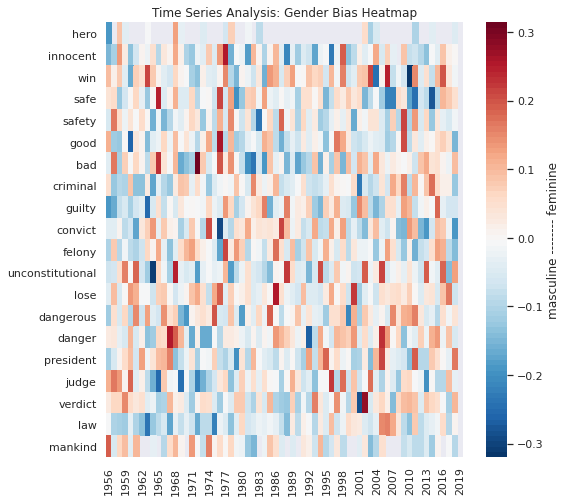

In [ ]:
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

positive_words = ["hero","innocent","win","safe",'safety',"good"]
negative_words = ['bad',"criminal", "guilty", "convict", "felony", "unconstitutional", "lose", "dangerous", "danger"]
neutral_words = ["president", "judge","verdict", "law", "mankind"]

all_words = positive_words + negative_words + neutral_words

def get_similarity(v1,v2):
	#Returns Cosine Similarity of two vectors
	return np.dot(v1,v2)/np.sqrt((np.dot(v1,v1))*(np.dot(v2,v2)))

data = []
for word in all_words:
  word_row = []
  for year in avg_gender_vectors:
    try:
      fem_vec, masc_vec, model = avg_gender_vectors[year]
      v1 = get_word_vector_from_model(word, model)
      fem_score = get_similarity(fem_vec, v1)
      masc_score = get_similarity(masc_vec, v1)
      word_row.append(fem_score - masc_score)
    except:
      word_row.append(np.nan) # No data for current year
  data.append(word_row)


df = pd.DataFrame(data, index=all_words, columns=[year for year in avg_gender_vectors])
plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_title('Time Series Analysis: Gender Bias Heatmap')
heatmap = sns.heatmap(df, cmap=sns.color_palette("RdBu_r", 80), ax=ax,cbar_kws={'label': 'masculine -------- feminine'})

#### Observations
Overall, similarity scores seem random. There does not seem to be trends over the years for a group of words, either positive or negative. 

Some interesting observations:
- **dangerous**, **lose** are consistanly more similar to **feminine** words
- **dangerous** and **danger** have drastically different values
- **law** is consistanly more similar to **masculine** words

Also note, the data is highly influenced by the seed words in the femininity and masculinity vectors. Adding or removing certain words causes drastically different results in the resulting heatmap.

### Opposite Word Comparisons
For pairs of opposite words, track their similarity to the femininity and masculinity vector over time.


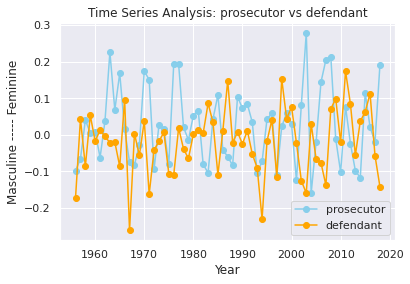

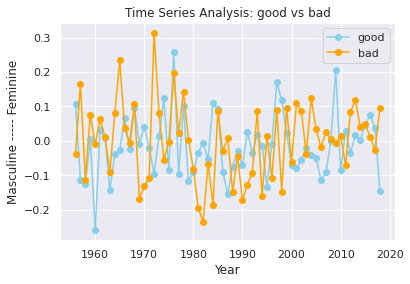

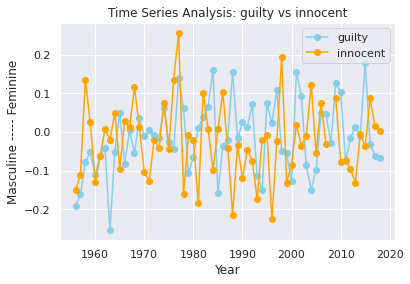

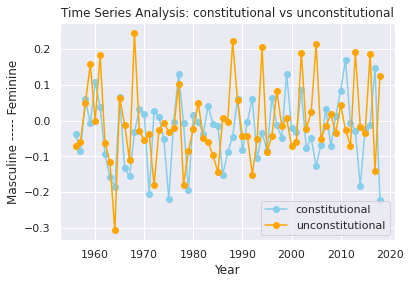

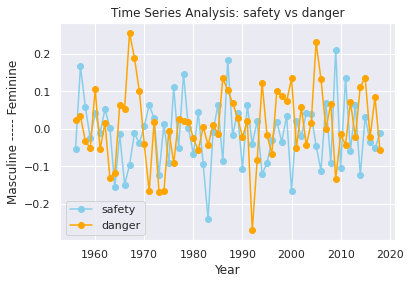

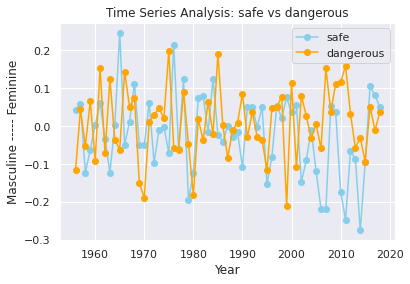

In [ ]:
opposites = [('prosecutor', 'defendant'),('good', 'bad'), ('guilty', 'innocent'), ('constitutional', 'unconstitutional'), ('safety', 'danger'), ('safe', 'dangerous')]

for pairs in opposites:
  data = []
  for word in pairs:
    score_row = []
    for year in avg_gender_vectors:
      try:
        # Get similarity scores
        fem_vec, masc_vec, model = avg_gender_vectors[year]
        v1 = get_word_vector_from_model(word, model)
        fem_score = get_similarity(fem_vec, v1)
        masc_score = get_similarity(masc_vec, v1)
        score_row.append(fem_score - masc_score)
      except:
        score_row.append(np.nan) # No data for current year
    data.append(score_row)
  # Plot data
  df=pd.DataFrame({"x":[x for x in avg_gender_vectors], pairs[0]:data[0], pairs[1]:data[1]})
  plt.plot('x', pairs[0], data=df, marker='o', color='skyblue')
  plt.plot('x', pairs[1], data=df, marker='o', color='orange')
  plt.title("Time Series Analysis: " + pairs[0] + " vs " + pairs[1])
  plt.xlabel("Year")
  plt.ylabel("Masculine ----- Feminine")
  plt.legend()
  plt.show()



#### Observations


We expect words to have stable trends over time, either staying consistent towards one end or shifting over time between masculine and feminine. Instead, the charts above show drastic polar flips from year to year without noticable trends.

The results clearly contradict the proposed hypotheses. Insufficient data or poorly trained models could be the cause.
